In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readxl)
library(httr)

set.seed(1)
options(repr.plot.height = 7, repr.plot.width = 11)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
packageVersion("readxl")
# [1] ‘0.1.1’
url = "https://github.com/danizenarosa/dsci-100-grp43/raw/main/data/birds.xlsx"
GET(url, write_disk(tf <- tempfile(fileext = ".xlsx")))
birds_data <- read_excel(tf, 2, col_types = "text") |>
              mutate(Total.individuals = as.numeric(Total.individuals), across(Beak.Length_Culmen:Mass, as.numeric)) |>
              mutate(Beak.Length = Beak.Length_Culmen,
                    Nares = Beak.Length_Nares,
                    Family = Family1,
                    Secondary = Secondary1,
                    HandWing.Index = `Hand-Wing.Index`) |>
              select(Family, Total.individuals, Beak.Length, Nares, Beak.Width:Kipps.Distance, Secondary, HandWing.Index, Tail.Length, Mass)
birds_count <- birds_data |>
    group_by(Family) |>
    summarize(count = sum(Total.individuals), across(Beak.Length:Mass, mean)) |> 
    slice_max(count, n = 10)  
 

birds_count

[1] ‘1.4.3’

Response [https://raw.githubusercontent.com/danizenarosa/dsci-100-grp43/main/data/birds.xlsx]
  Date: 2024-04-05 00:46
  Status: 200
  Content-Type: application/octet-stream
  Size: 21.5 MB
<ON DISK>  /tmp/RtmpjWrybN/file1504278b2365.xlsxNULL

Family,count,Beak.Length,Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary,HandWing.Index,Tail.Length,Mass
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Thraupidae,4988,14.98162,9.151471,5.147059,6.517402,20.008088,73.55637,13.916176,59.51912,18.84118,59.21642,23.264240
Tyrannidae,4670,15.56258,9.114031,5.036748,4.019154,18.646771,71.56526,14.118040,57.40601,18.39532,61.27528,17.638731
Furnariidae,3878,22.19301,15.050760,3.935866,4.908511,22.293313,80.44681,13.644681,66.80365,16.38172,79.69544,30.622097
Trochilidae,3232,23.85738,18.869672,2.165574,2.053279,5.131148,57.00355,35.921038,20.89918,63.43224,40.48607,5.136995
Muscicapidae,2927,16.52776,9.501493,4.050448,4.124478,23.618209,81.11552,15.688657,65.33761,19.14179,64.11015,24.417015
Thamnophilidae,2868,18.38388,10.777273,4.492149,4.857851,22.309917,63.35909,6.833884,57.16033,10.83967,52.60868,20.520620
Psittacidae,2212,25.13895,20.775263,12.623421,21.402632,16.787895,152.61053,60.650789,91.83684,40.39026,114.55868,166.488474
Columbidae,2197,22.42493,11.301133,4.667422,5.226912,27.532295,169.17167,53.297167,115.84533,31.12011,112.45552,257.899122
Pycnonotidae,2003,19.73671,11.323418,4.498101,5.304430,19.901266,91.59810,14.243038,77.30633,15.30506,85.13608,35.827025


[1] "Thraupidae"     "Tyrannidae"     "Furnariidae"    "Trochilidae"   
 [5] "Muscicapidae"   "Thamnophilidae" "Psittacidae"    "Columbidae"    
 [9] "Pycnonotidae"   "Parulidae"

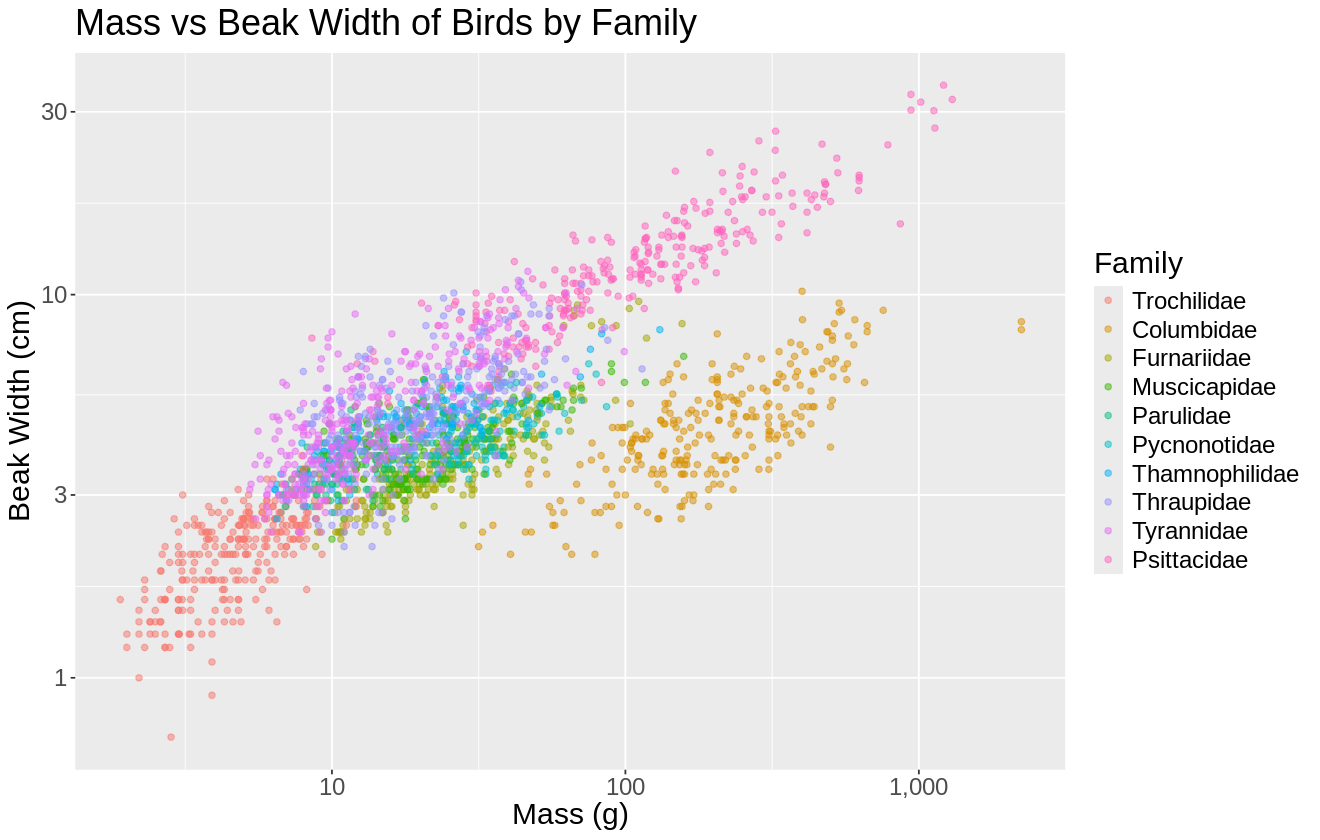

In [6]:
birds_top_10 <- birds_count |>
                pull(Family)
birds_top_10

birds_data_pruned <- filter(birds_data, Family %in% birds_top_10) |>
    mutate(Family = as_factor(Family))

split_birds <- initial_split(birds_data_pruned, prop = 0.75, strata = Family)
training_birds <- training(split_birds)
test_birds <- testing(split_birds)

bird_beak_mass_plot <- training_birds |>
    ggplot(aes(x = Mass, y = Beak.Width, color = Family)) +
    geom_point(alpha = .5) +
    labs(x = "Mass (g)", y = "Beak Width (cm)", color= "Family", title = "Mass vs Beak Width of Birds by Family") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    theme(text = element_text(size = 18))

bird_beak_mass_plot

[1] "Thraupidae"     "Tyrannidae"     "Furnariidae"    "Trochilidae"   
 [5] "Muscicapidae"   "Thamnophilidae" "Psittacidae"    "Columbidae"    
 [9] "Pycnonotidae"   "Parulidae"

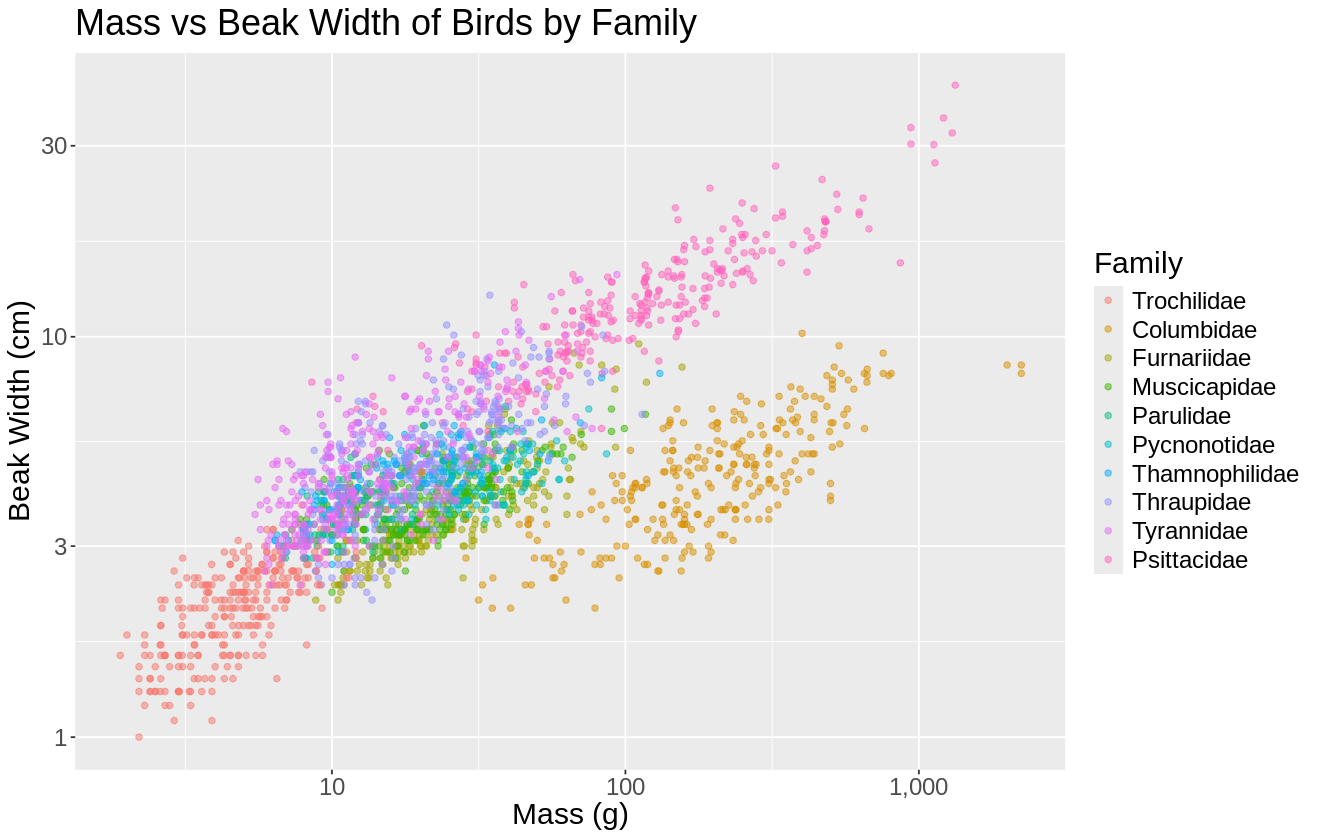

In [8]:
birds_top_10 <- birds_count |>
                pull(Family)
birds_top_10


split_birds <- initial_split(birds_data_pruned, prop = 0.75, strata = Family)
training_birds <- training(split_birds)
test_birds <- testing(split_birds)

bird_beak_mass_plot <- training_birds |>
    ggplot(aes(x = Mass, y = Beak.Width, color = Family)) +
    geom_point(alpha = .5) +
    labs(x = "Mass (g)", y = "Beak Width (cm)", color= "Family", title = "Mass vs Beak Width of Birds by Family") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    theme(text = element_text(size = 18))

bird_beak_mass_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8266182,5,0.006650782,Preprocessor1_Model01
2,accuracy,multiclass,0.8266182,5,0.006650782,Preprocessor1_Model02
3,accuracy,multiclass,0.8385187,5,0.005336271,Preprocessor1_Model03
4,accuracy,multiclass,0.8427695,5,0.006403923,Preprocessor1_Model04
5,accuracy,multiclass,0.8457247,5,0.006086828,Preprocessor1_Model05
6,accuracy,multiclass,0.8436024,5,0.006771383,Preprocessor1_Model06
7,accuracy,multiclass,0.8308761,5,0.009588445,Preprocessor1_Model07
8,accuracy,multiclass,0.8321491,5,0.010243022,Preprocessor1_Model08
9,accuracy,multiclass,0.8330174,5,0.011232975,Preprocessor1_Model09


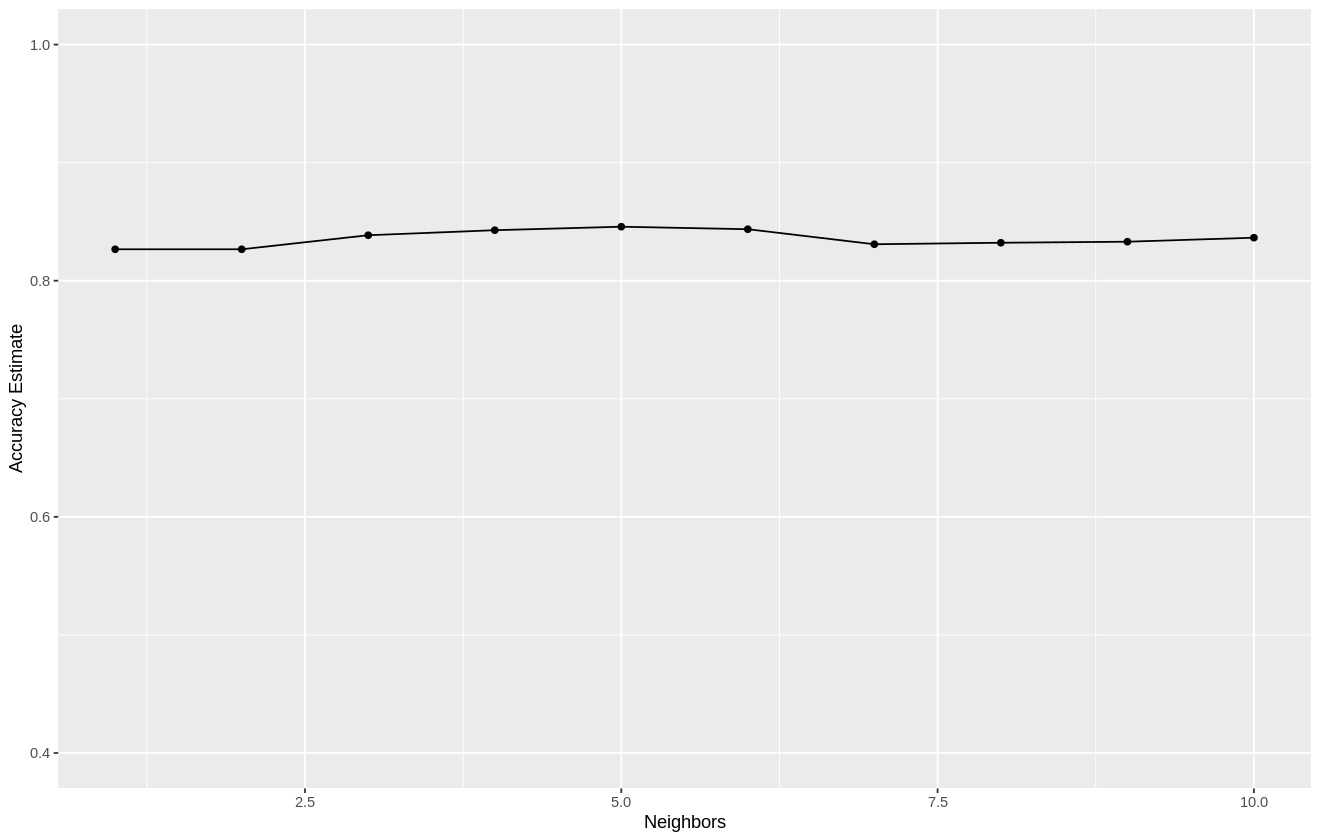

In [9]:


birds_vfold <- vfold_cv(training_birds, v = 5, strata = Family)

knn_tune <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

birds_recipe <- recipe(Family ~ ., data = training_birds) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

birds_results <- workflow() |>
    add_recipe(birds_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = birds_vfold, grid = k_vals) |>
    collect_metrics()


accuracies <- birds_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_y_continuous(limits = c(0.4, 1.0))
cross_val_plot
accuracies

In [10]:
birds_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

birds_fit <- workflow() |>
    add_recipe(birds_recipe) |>
    add_model(birds_spec) |>
    fit(data = training_birds)

birds_predictions <-   predict(birds_fit, test_birds) |>
  bind_cols(test_birds)

birds_metrics <- metrics(birds_predictions, truth = Family, estimate = .pred_class) |>
    filter(.metric == "accuracy")

birds_conf_mat <- conf_mat(birds_predictions, truth = Family, estimate = .pred_class)

birds_metrics
birds_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8669202


                Truth
Prediction       Trochilidae Columbidae Furnariidae Muscicapidae Parulidae
  Trochilidae             91          0           0            0         0
  Columbidae               0         80           0            1         0
  Furnariidae              0          0          72            1         0
  Muscicapidae             0          0           2           54         0
  Parulidae                0          1           4            2        21
  Pycnonotidae             0          0           1            3         0
  Thamnophilidae           0          0           0            1         1
  Thraupidae               0          0           0            5         6
  Tyrannidae               0          0           0           15         2
  Psittacidae              0          0           0            0         0
                Truth
Prediction       Pycnonotidae Thamnophilidae Thraupidae Tyrannidae Psittacidae
  Trochilidae               0              0        

In [11]:
# accuracies <- tibble(size = integer(),
#                      model_string = character(),
#                      accuracy = numeric())



# # store the total number of predictors
# names <- colnames(training_birds |> select(-Family))
# n_total <- length(names)

# # stores selected predictors
# selected <- c()

# # for every size from 1 to the total number of predictors
# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         # create a model string for this combination of predictors
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("Family", "~", paste(preds_new, collapse="+"))

#         # create a recipe from the model string
#         cancer_recipe <- recipe(as.formula(model_string),
#                                 data = training_birds) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

#         # tune the K-NN classifier with these predictors,
#         # and collect the accuracy for the best K
#         acc <- workflow() |>
#           add_recipe(birds_recipe) |>
#           add_model(knn_tune) |>
#           tune_grid(resamples = birds_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

#         # add this result to the dataframe
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies |>
#       add_row(size = i,
#               model_string = models[[jstar]],
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }
# accuracies